## Autoencoder

### Transposed Convolution

<img src="./rsc/transposed_convolution.png" width="600" height="800">

#### Output 
$$O = S \cdot (I-1)+K -2 \cdot P$$

In [1]:
import torch
from torch import nn

In [3]:
def conv_transpose2d(input, weight, stride=1, padding=0):

    batch_size, in_ch, in_h, in_w = input.shape
    _, out_ch, f_h, f_w = weight.shape

    h_out = stride * (in_h - 1) + f_h - 2 * padding
    w_out = stride * (in_w - 1) + f_w - 2 * padding
    
    output = torch.zeros(batch_size, out_ch, h_out, w_out)
    for b in range(batch_size):
        for i in range(in_ch):
            for o in range(out_ch):
                for h in range(in_h):
                    for w in range(in_w):
                        h_start = h * stride - padding
                        w_start = w * stride - padding
                        for f_h_idx in range(f_h):
                            for f_w_idx in range(f_w):
                                h_out_idx = h_start + f_h_idx
                                w_out_idx = w_start + f_w_idx

                                if 0<= h_out_idx < h_out and 0<= w_out_idx < w_out:
                                    output[b, o, h_out_idx, w_out_idx] += input[b,i,h,w] * weight[i,o,f_h_idx, f_w_idx]


    return output
        

In [4]:
input = torch.randn(1,3,5,5)
weight = torch.randn(3,16,3,3)
output = conv_transpose2d(input, weight, stride=2, padding=2)
print(output.shape)

torch.Size([1, 16, 7, 7])


### Transposed Convolution in Pytorch

In [5]:
convt_layer = nn.ConvTranspose2d(3, 16, kernel_size=3, stride=2, padding=2, bias=False)
output = convt_layer(input)
output.shape

torch.Size([1, 16, 7, 7])

In [6]:
weight = convt_layer.weight
output_scratch = conv_transpose2d(input, weight, stride=2, padding=2)
torch.allclose(output, output_scratch)

True

### Autoencoder

It is typically used for dimensionality reduction, feature learning, and data compression.

In [135]:
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [151]:
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root="./data/mnist_data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

val_dataset = torchvision.datasets.MNIST(root="./data/mnist_data", train=False, download=True, transform=transform)
val_loader = DataLoader(train_dataset, batch_size=128, num_workers=4)

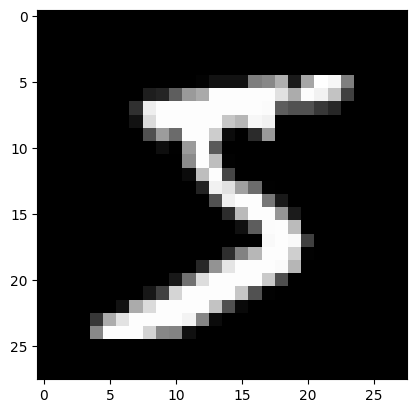

In [42]:
im, label = train_dataset[0]
plt.imshow((im/2 +0.5)[0,:,:], cmap='gray')

In [33]:
def calc_conv_output(in_channels, kernel_size, stride=1, padding=0):
    return (in_channels - kernel_size + 2 * padding) / stride + 1

In [160]:
calc_conv_output(1,16,3,padding=1)

-3.333333333333333

In [51]:
def calc_tconv_output(in_channels, kernel_size, stride=1, padding=0):
    # output size = stride x (input -1) + kernel size - 2 x padding
    return (in_channels - 1) * stride + kernel_size - 2 * padding

In [76]:
calc_tconv_output(4, 4,2, 2)

14

In [152]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # encoder
        self.conv1 = nn.Conv2d(1,16,3,padding=1)
        self.conv2 = nn.Conv2d(16,4,3,padding=1)
        self.pool = nn.MaxPool2d(2,2)

        # decoder
        self.t_conv1 = nn.ConvTranspose2d(4,16,2,stride=2) # double C,W,H
        self.t_conv2 = nn.ConvTranspose2d(16,1,2,stride=2)

    def forward(self, X):
        #encoder
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        #decoder
        X = F.relu(self.t_conv1(X))
        X = F.sigmoid(self.t_conv2(X))
        
        return X

In [153]:
model = ConvAutoencoder()
opt = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 10

In [154]:
for epoch in range(1, num_epochs+1):
    train_loss =0.0

    for X, _ in train_loader:
        opt.zero_grad()
        outputs = model(X)
        loss = F.mse_loss(outputs, X)
        loss.backward()
        opt.step()
        train_loss += loss.item()*X.shape[0]
    train_loss = train_loss / len(train_loader)
    print(f'Epoch: {epoch}: train loss: {train_loss}')

Epoch: 1: train loss: 6.117661875829514
Epoch: 2: train loss: 2.093293751989092
Epoch: 3: train loss: 1.9517606088220438
Epoch: 4: train loss: 1.8822201097697846
Epoch: 5: train loss: 1.8290694335630453
Epoch: 6: train loss: 1.7828581040856173
Epoch: 7: train loss: 1.7431714623086234
Epoch: 8: train loss: 1.707344602293043
Epoch: 9: train loss: 1.6747386765632548
Epoch: 10: train loss: 1.6419245118398402


In [155]:
# test
val_loader = DataLoader(val_dataset, batch_size=8)
images, labels = next(iter(val_loader))
outputs = model(images)

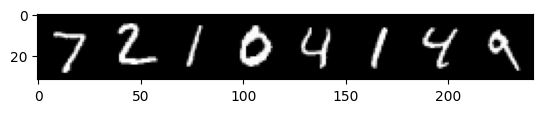

In [158]:
images_grid = torchvision.utils.make_grid(images)
outputs_grid = torchvision.utils.make_grid(outputs)
# orignal image
plt.imshow(torch.permute(images_grid, (1, 2, 0)))

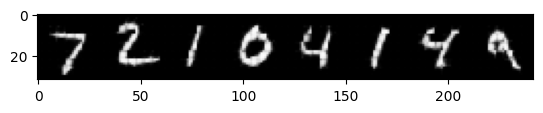

In [159]:
plt.imshow(torch.permute(outputs_grid, (1, 2, 0)))